# Wildfire Data Analysis

### Challenge: Tell a story about wildfire in an area of my choice. wildfire analysis.

### Description
* I choose any location
* implement a fire data analysis based on different datasets.
* investigate an area that is familiar to me/interesting to me
* Area size between min. 10x10km and max. 500x500km
* max time span : 10 years

### Input Data
Burned Area : MODIS burned area (grid OR pixel)
#### Additional data:
vegetation/ land cover classes (very large size - import as "static"feature containing only 1 year.)
meteorological data (2 options)
    - ERA5 hourly or monthly

### Output
* Jupyter notebok on my github account that includes the hypothesis & data analytics
* data download scripts
* data preprocessing can either be done in an additional notebook or python script

### Suggested Workflow
* work on github & jupyter notebook
* decide on an area of interest, check if this area has wildfire occurrences before, e.g. with NASA FIRMS
* familiarize myself briefly with the content, spatial and temporal resolution of the available datasets
* form 2 hypotheses I would like to test based on the data
* select variables for my area of interest based on my hypothesis
* download selected data, overcome potential challenges with the data download
* test my hypothesis using data visualization and data analytics

#### Input Data
MODIS burned area for 2019(grid)

In [1]:
# Import necessary modules

import sys
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import xarray as xr
import copy
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
import scipy
from scipy import sparse

In [2]:
%cd "/Users/seungheejeong/Desktop/dataset/MODIS-burned-area/"

/Users/seungheejeong/Desktop/dataset/MODIS-burned-area


### Additional ERA5 Dataset
Year : 2019 

variables:
<!-- * d2m :2m dewpoint temperature,  -->
* t2m: 2m temperature, 
* tp: Total precipitation
* cbh: Cloud base height, 
* tcc: Total cloud cover, 
* hcc: High cloud cover,
* mcc: Medium cloud cover,
* lcc: Low cloud cover, 
* hvc: High vegetation cover,
* cvl: Low vegetation cover,
etc.

<!-- * lai_hv: Leaf area index high vegetation, 
* lai_hv: Leaf area index low vegetation,  -->
 
 
<!-- Sea surface temperature, 
Skin temperature, 
Surface pressure, 
Total cloud cover, 
Total column cloud ice water, 
Total column cloud liquid water, 
Total precipitation, 
Type of high vegetation, 
Type of low vegetation, 
Vertical integral of temperature -->

In [3]:
'''HOW TO GENERATE ANNUAL BA FROM THE 0.25 GRID PRODUCT'''
import netCDF4
import numpy as np
netCDF_image_path = '/Users/seungheejeong/Desktop/dataset/adaptor.mars.internal-1654039013.4349856-12877-7-44acbbf4-7073-4f63-bcf4-1c30117b7fdc.nc'

# Open the image to store it in an object.
ERA5 = netCDF4.Dataset(netCDF_image_path, 'r')
print(ERA5.__dict__)
for var_name in ERA5.variables:
    print('--------------------', var_name)

_lat = ERA5.variables['latitude'][:].data
_lon = ERA5.variables['longitude'][:].data
time = ERA5.variables['time'][:].data
tp = ERA5.variables['tp'][:].data   # Total precipitation
tcc = ERA5.variables['tcc'][:].data # Total cloud cover
hcc = ERA5.variables['hcc'][:].data # High cloud cover
mcc = ERA5.variables['mcc'][:].data # Medium cloud cover
lcc = ERA5.variables['lcc'][:].data # Low cloud cover
hvc = ERA5.variables['cvh'][:].data # High vegetation cover
cvl = ERA5.variables['cvl'][:].data # Low vegetation cover

# Iterate over each month of the year.
for time in range(0, time.size):


    if time == 0:
        total_tp = ERA5.variables['tp'][time].data
        total_tcc = ERA5.variables['tcc'][time].data
        total_hcc = ERA5.variables['hcc'][time].data
        total_lcc = ERA5.variables['lcc'][time].data
        total_mcc = ERA5.variables['mcc'][time].data
        total_hvc = ERA5.variables['cvh'][time].data
        total_cvl = ERA5.variables['cvl'][time].data           

    else:

        total_tp = total_tp + ERA5.variables['tp'][time].data
        total_tcc = total_tcc + ERA5.variables['tcc'][time].data
        total_hcc = total_hcc + ERA5.variables['hcc'][time].data
        total_mcc = total_mcc + ERA5.variables['mcc'][time].data
        total_lcc = total_lcc + ERA5.variables['lcc'][time].data
        total_hvc = total_hvc + ERA5.variables['cvh'][time].data
        total_cvl = total_cvl + ERA5.variables['cvl'][time].data

   

{'Conventions': 'CF-1.6', 'history': '2022-05-31 23:18:43 GMT by grib_to_netcdf-2.24.3: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1654039013.4349856-12877-7-44acbbf4-7073-4f63-bcf4-1c30117b7fdc.nc /cache/tmp/44acbbf4-7073-4f63-bcf4-1c30117b7fdc-adaptor.mars.internal-1654038875.657431-12877-10-tmp.grib'}
-------------------- longitude
-------------------- latitude
-------------------- time
-------------------- d2m
-------------------- t2m
-------------------- cbh
-------------------- e
-------------------- hcc
-------------------- cvh
-------------------- lai_hv
-------------------- lai_lv
-------------------- lcc
-------------------- cvl
-------------------- mcc
-------------------- sst
-------------------- skt
-------------------- sp
-------------------- tcc
-------------------- tciw
-------------------- tclw
-------------------- tp
-------------------- tvh
-------------------- tvl
-------------------- p54.162


#### Burned Area : MODIS burned area (grid ver.)

In [4]:
'''HOW TO GENERATE ANNUAL BA FROM THE 0.25 GRID PRODUCT'''
import netCDF4
import numpy as np
image_folder_path = '/Users/seungheejeong/Desktop/dataset/MODIS-burned-area'
# netCDF_band_name = 'burned_area' # See Table 3 of the tutorial document for the
# different band names

def get_yearly_data(netCDF_band_name):
    yearly__dict = {}

    for year in range(2015,2020):
        # Iterate over each month of the year.
        for month in range(1, 13):
            # Generate the path to the grid product of the defined year and month.
            netCDF_image_path = '%s/%04d%02d01-ESACCI-L4_FIRE-BA-MODIS-fv5.1.1cds.nc' %(image_folder_path, year, month)
            # Open the image to store it in an object.
            object_netCDF = netCDF4.Dataset(netCDF_image_path, 'r')
            # Access the names of all the bands stored in the image.
            band_netCDF = object_netCDF.variables
            # Access the band that contains the burned area
            monthly_data = np.array(band_netCDF[netCDF_band_name])[0]

            if month == 1:
                # If the defined month is January it is necessary to initialize the
                # variable that will contain the annual burned area.
                print(f'{year}-{month}-th month data is combining...')
                annual_data = np.copy(monthly_data)
            else:
                # If the defined month is not January it means that the variable that
                # contain the annual burned area already exists. Therefore, the burned
                # area of the current month is added to the annual one.
                annual_data = annual_data + monthly_data

        if year == 2015:
            total_annual_data = annual_data
        else:
            total_annual_data = total_annual_data + annual_data
        yearly__dict[str(year)] = annual_data
    return object_netCDF,total_annual_data

In [5]:
df ,total_annual_BA = get_yearly_data('burned_area')
df, total_annual_error = get_yearly_data('standard_error')


2015-1-th month data is combining...
2016-1-th month data is combining...
2017-1-th month data is combining...
2018-1-th month data is combining...
2019-1-th month data is combining...
2015-1-th month data is combining...
2016-1-th month data is combining...
2017-1-th month data is combining...
2018-1-th month data is combining...
2019-1-th month data is combining...


In [6]:
for var_name in df.variables:
    print('--------------------', var_name)
#     print(df.variables[var_name][:1].data)

burned_area = df['burned_area'][:].data
standard_error = df.variables['standard_error'][:].data
fraction_of_burnable_area = df.variables['fraction_of_burnable_area'][:].data
fraction_of_observed_area = df.variables['fraction_of_observed_area'][:].data
lat = df.variables['lat'][:].data
lat_bounds = df.variables['lat_bounds'][:].data
lon = df.variables['lon'][:].data
lon_bounds = df.variables['lon_bounds'][:].data
time = df.variables['time'][:].data
time_bounds = df.variables['time_bounds'][:].data
vegetation_class = df.variables['vegetation_class'][:].data
vegetation_class_name = df.variables['vegetation_class_name'][:].data

-------------------- burned_area
-------------------- standard_error
-------------------- fraction_of_burnable_area
-------------------- fraction_of_observed_area
-------------------- number_of_patches
-------------------- burned_area_in_vegetation_class
-------------------- lat
-------------------- lat_bounds
-------------------- lon
-------------------- lon_bounds
-------------------- time
-------------------- time_bounds
-------------------- vegetation_class
-------------------- vegetation_class_name


In [7]:
print(total_annual_BA.shape)
print(total_annual_BA.size)

(720, 1440)
1036800


### Convert to Sparse Matrix

In [8]:
print("Share of entries that are zero: ", 1 - (np.count_nonzero(total_annual_BA) / total_annual_BA.size))
print("Non zero: ", (np.count_nonzero(total_annual_BA) / total_annual_BA.size))


Share of entries that are zero:  0.913370949074074
Non zero:  0.08662905092592593


In [9]:
def convert_to_sparse(total_annual_data):
    sparse_matrix = scipy.sparse.csr_matrix(total_annual_data)

    print(f"Shape ({sparse_matrix.shape}) stays the same!")
    print(f"Size of original image: {sys.getsizeof(total_annual_data)} bytes")
    print(f"Size of sparse matrix: {sys.getsizeof(sparse_matrix)} bytes")
    print(f"=> Reduction: {100 - 100 * sys.getsizeof(sparse_matrix) / sys.getsizeof(total_annual_data)}")
    return sparse_matrix

def convert_to_dense(sparse_matrix):
    dense_matrix = sparse_matrix.toarray()
    print(f"Size of dense matrix:{sys.getsizeof(dense_matrix)}")
    return dense_matrix

In [10]:
sparse_burned_area = convert_to_sparse(total_annual_BA)
sparse_error = convert_to_sparse(total_annual_error)

Shape ((720, 1440)) stays the same!
Size of original image: 4147328 bytes
Size of sparse matrix: 48 bytes
=> Reduction: 99.99884262831394
Shape ((720, 1440)) stays the same!
Size of original image: 4147328 bytes
Size of sparse matrix: 48 bytes
=> Reduction: 99.99884262831394


### Convert back to dense matrix (runs really fast)

In [11]:
dense_BA = convert_to_dense(sparse_burned_area)
dense_error = convert_to_dense(sparse_error)

Size of dense matrix:4147328
Size of dense matrix:4147328


In [12]:
dense_BA.shape

(720, 1440)

### Convert to dataframe

In [13]:
def convert_to_df(dense_matrix):
    df = pd.DataFrame(dense_matrix, index=lat, columns=lon)
    if (df.isnull().values.any()):
        print('WARN: There is NaN')
    else:
        print('There is NO NaN')
    return df

def convert_to_df_2(dense_matrix):
    df = pd.DataFrame(dense_matrix, index=_lat, columns=_lon)
    if (df.isnull().values.any()):
        print('WARN: There is NaN')
    else:
        print('There is NO NaN')
    return df

### Plotting Higher BA Area VS Anomaly BA Area - Comparing original data vs aggregated data 


In [14]:
# Anamoly BA
annual_BA = total_annual_BA
anomaly_BA = annual_BA - np.mean(annual_BA, axis=0)
# Show all areas with higher than mean BA
higher_BA = annual_BA > annual_BA.mean()
# plt.imshow(higher_BA, cmap=cm.coolwarm)

# Aggregated Anamoly BA
agg_anomaly_BA = dense_BA - np.mean(dense_BA, axis=0)
# Show all areas with higher than mean BA
agg_higher_BA = dense_BA > dense_BA.mean()
# plt.imshow(agg_higher_BA, cmap=cm.coolwarm)

/var/folders/65/s613crcx5d1ftx4d8ymtx36w0000gp/T/ipykernel_32729/3932404300.py:14: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im, orientation='horizontal')


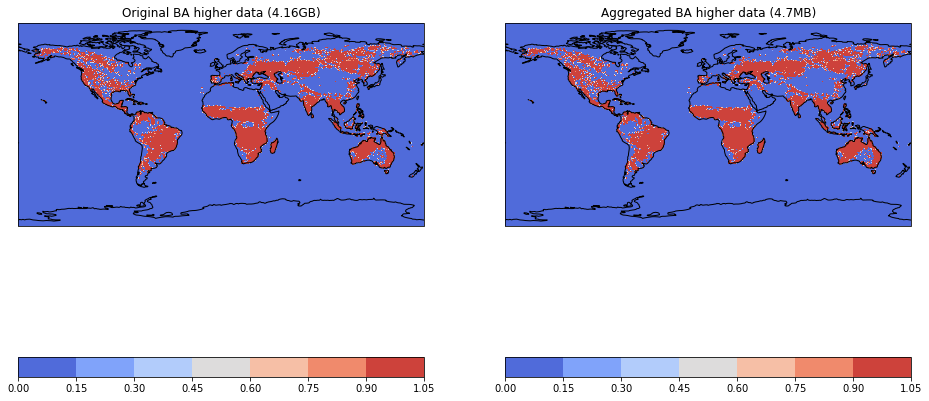

In [15]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,higher_BA,cmap=cm.coolwarm)
ax.set_title('Original BA higher data (4.16GB)')
fig.colorbar(im, orientation='horizontal')

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.contourf(lon,lat,agg_higher_BA,cmap=cm.coolwarm)
ax.set_title('Aggregated BA higher data (4.7MB)')
fig.colorbar(im, orientation='horizontal')

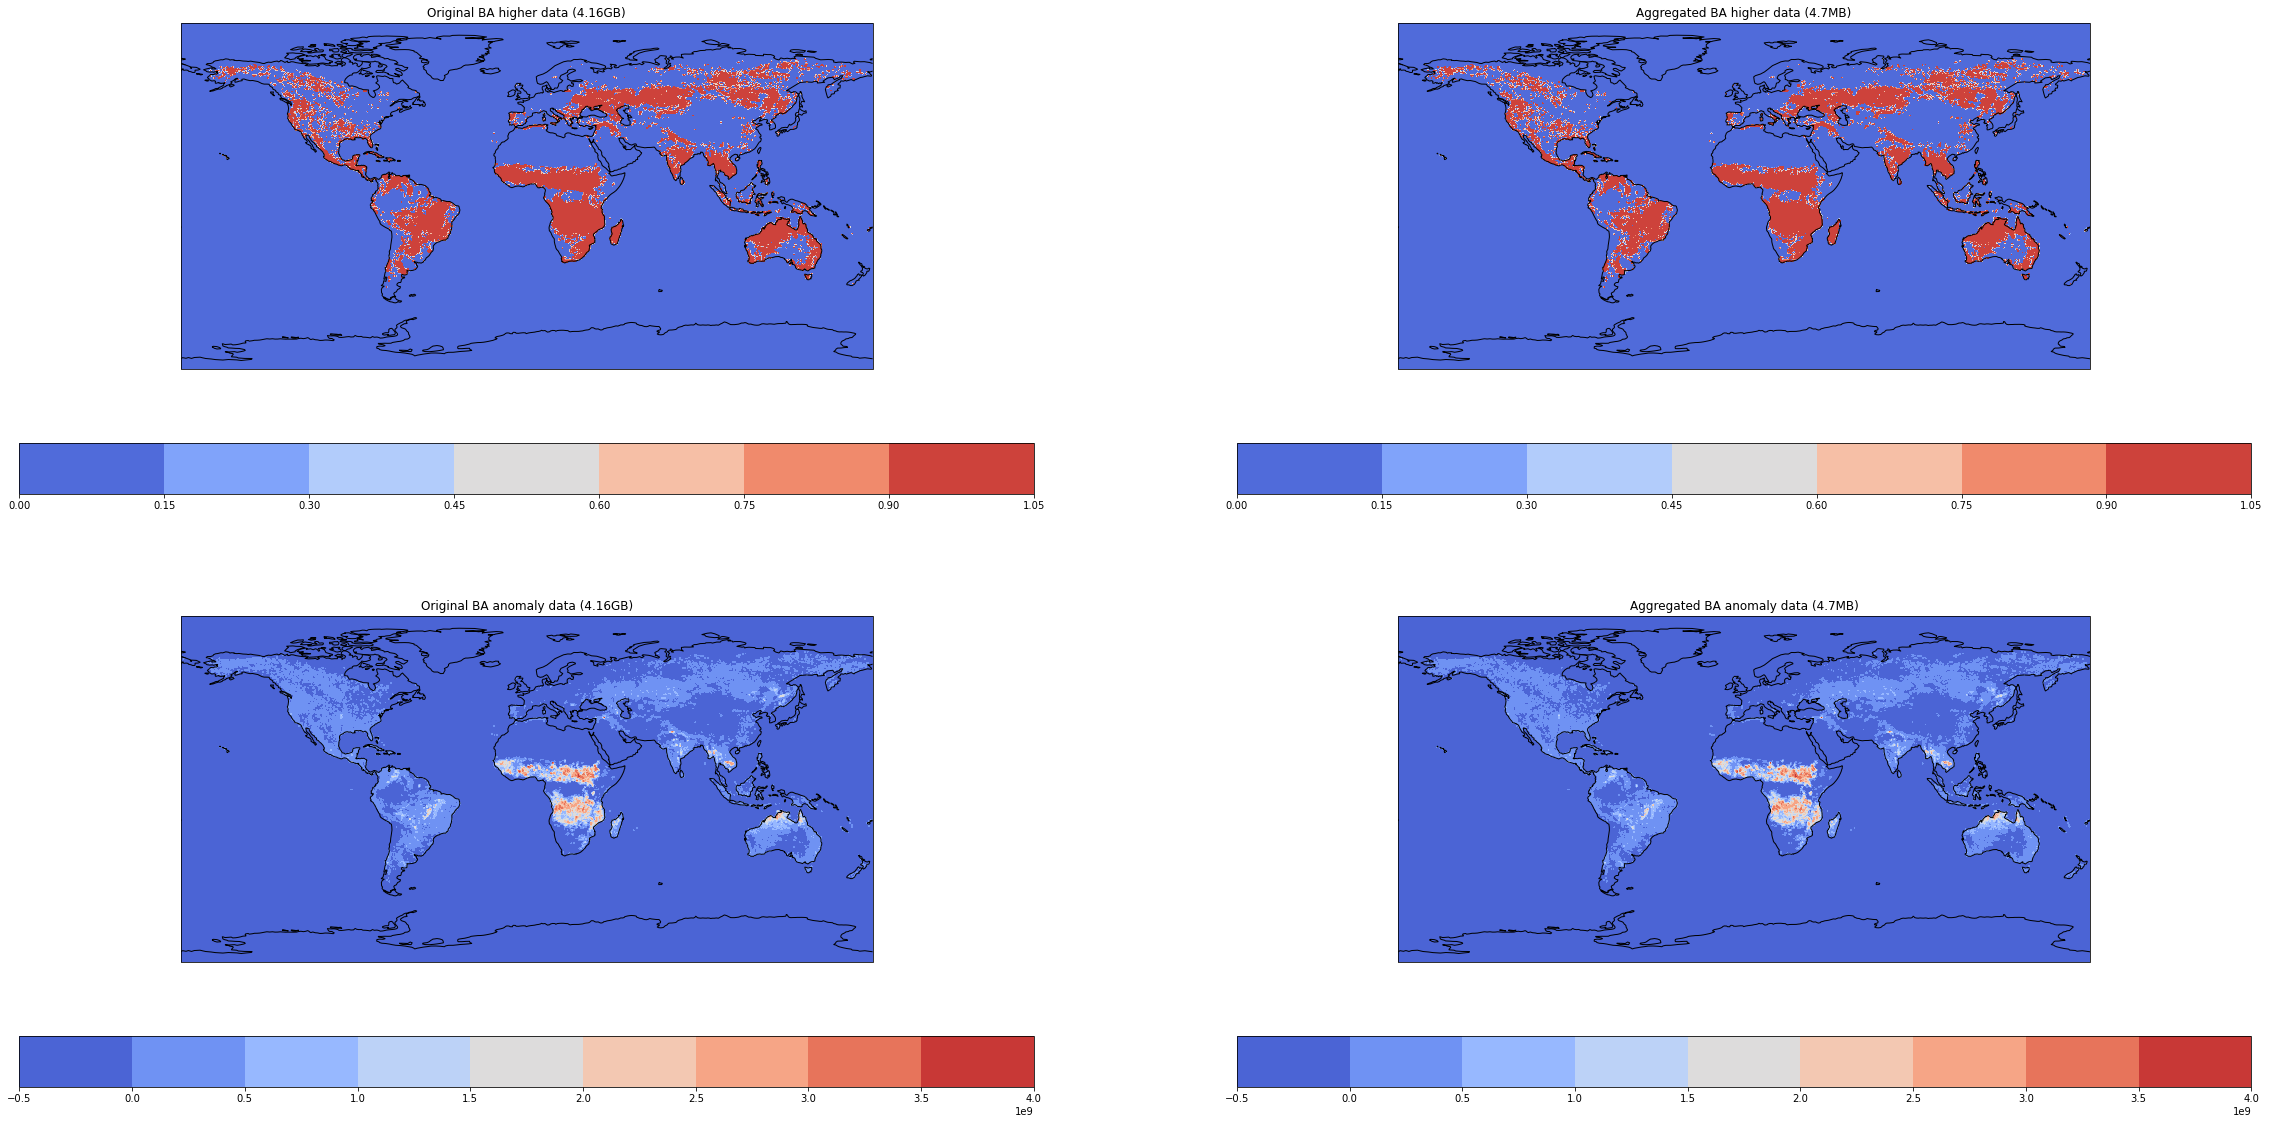

In [16]:
fig = plt.figure(figsize=(40,20))


ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,higher_BA,cmap=cm.coolwarm)
ax.set_title('Original BA higher data (4.16GB)')
fig.colorbar(im,location="bottom")

ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,agg_higher_BA,cmap=cm.coolwarm)
ax.set_title('Aggregated BA higher data (4.7MB)')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Original BA anomaly data (4.16GB)')
fig.colorbar(im,location="bottom")

ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,agg_anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Aggregated BA anomaly data (4.7MB)')
fig.colorbar(im, location='bottom')

#### Normalization

In [17]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [18]:
# Anamoly Error
annual_error = NormalizeData(total_annual_error)
dense_error = NormalizeData(dense_error)

# annual_error = total_annual_error
# dense_error = dense_error

# Aggregated Anomaly Error
agg_anomaly_error = dense_error - np.mean(dense_error, axis=0)
# Show all areas with higher than mean BA
agg_higher_error = dense_error > dense_error.mean()
# plt.imshow(agg_higher_BA, cmap=cm.coolwarm)

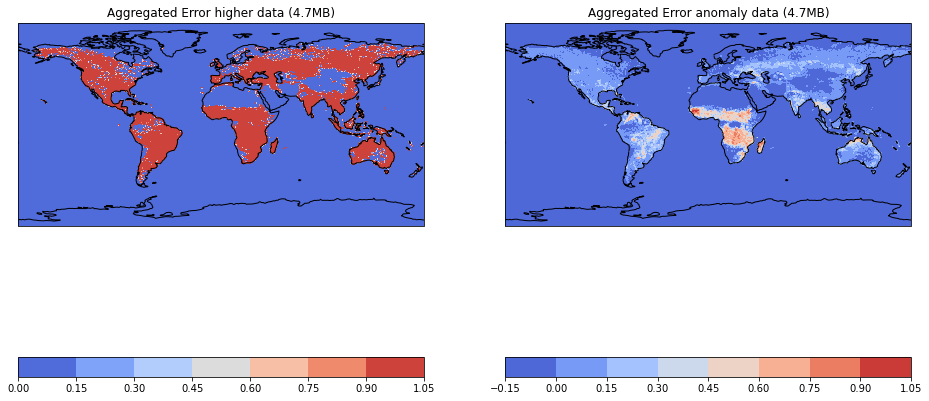

In [19]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,agg_higher_error,cmap=cm.coolwarm)
ax.set_title('Aggregated Error higher data (4.7MB)')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,agg_anomaly_error,cmap=cm.coolwarm)
ax.set_title('Aggregated Error anomaly data (4.7MB)')
fig.colorbar(im, location='bottom')

#### Plotting Higher BA Area

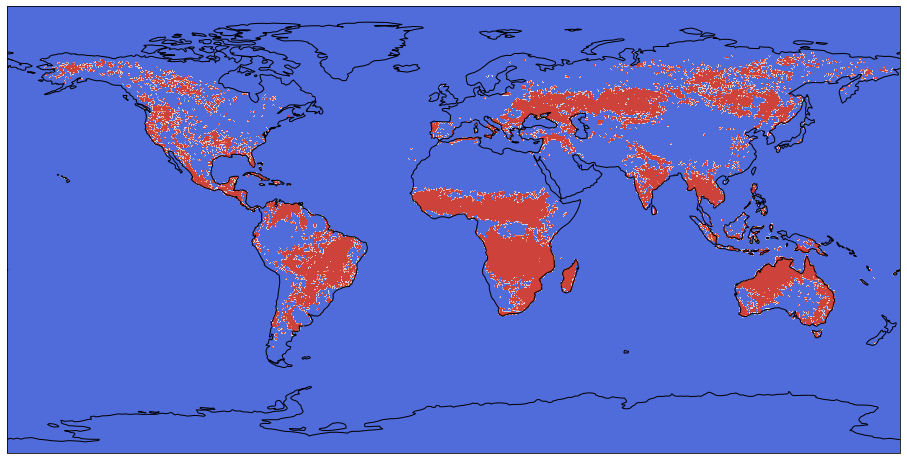

In [20]:
# plt.imshow(higher_BA, norm=norm, cmap=cm.coolwarm)
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.contourf(lon, lat, agg_higher_BA, cmap=cm.coolwarm)  # didn't use transform, but looks ok...
plt.show()

#### Plotting Anomaly BA Area

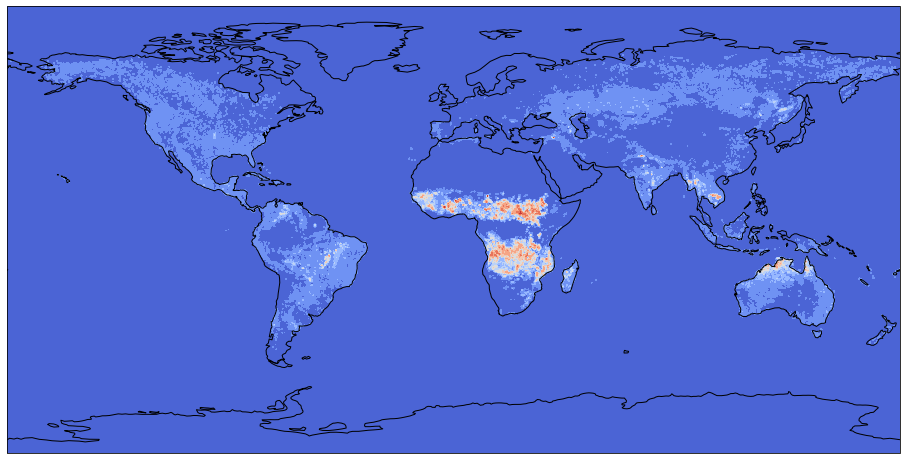

In [21]:
# plt.imshow(higher_BA, norm=norm, cmap=cm.coolwarm)
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.contourf(lon, lat, agg_anomaly_BA, cmap=cm.coolwarm)  # didn't use transform, but looks ok...
plt.show()

### Selecting the Area - Africa

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


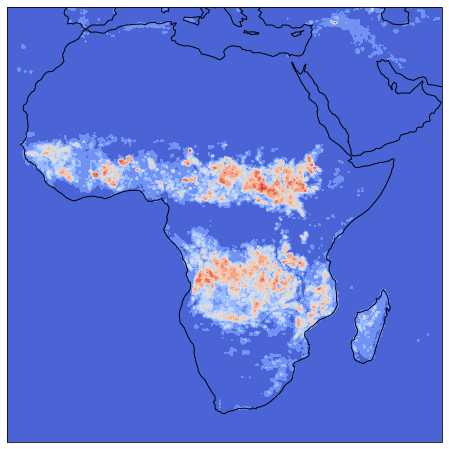

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


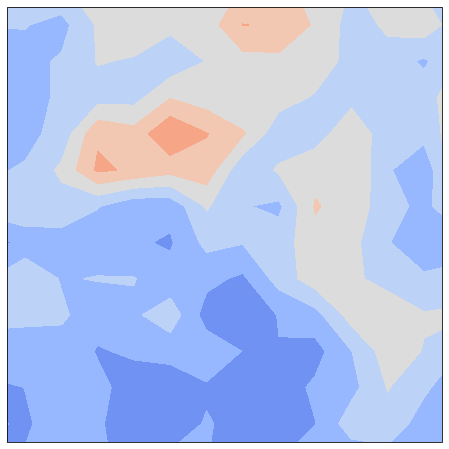

In [22]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
print(type(lon),type(lat))
ax.contourf(lon, lat, agg_anomaly_BA, cmap=cm.coolwarm)
plt.xlim([-20,60])
plt.ylim([-40,40])
plt.show()

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
print(type(lon),type(lat))
ax.contourf(lon, lat, agg_anomaly_BA, cmap=cm.coolwarm)
# plt.xlim([-20,60])
# plt.ylim([-40,40])
plt.xlim([-14,-11])
plt.ylim([11,14])
plt.show()


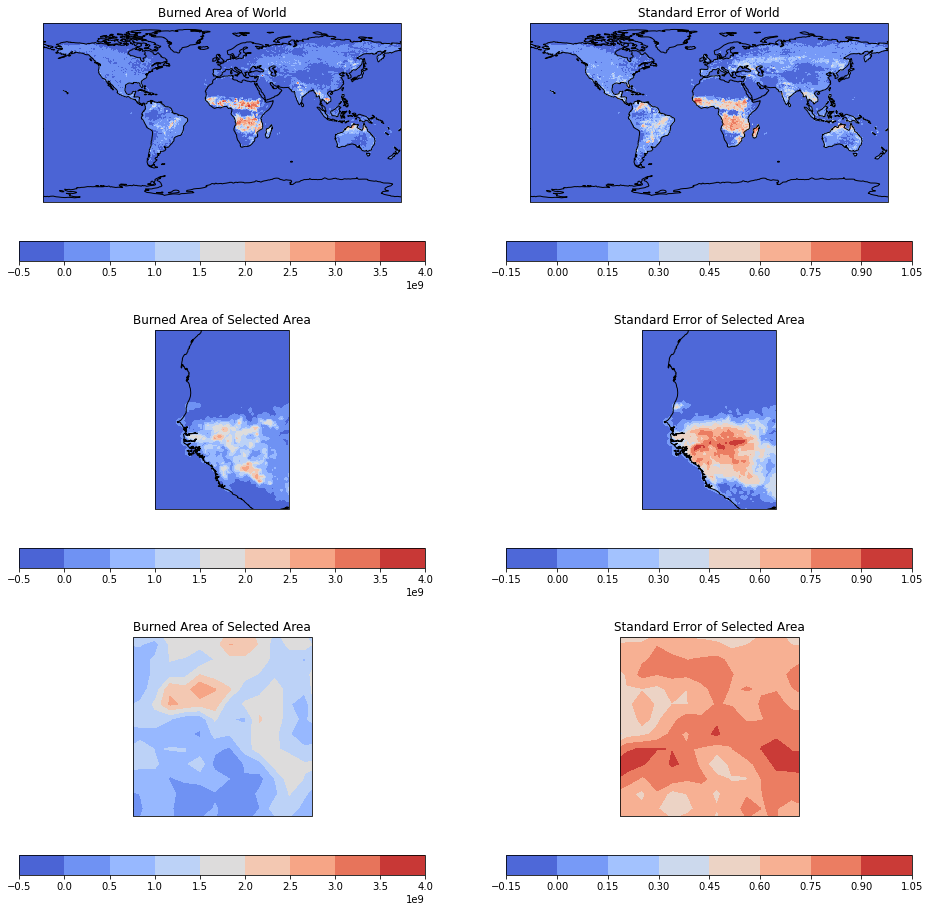

In [23]:
fig = plt.figure(figsize=(16,16))


ax = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,agg_anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of World')
fig.colorbar(im,location="bottom")

ax = fig.add_subplot(3, 2, 2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon, lat, agg_anomaly_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of World')
fig.colorbar(im,location="bottom")

ax = fig.add_subplot(3, 2, 3, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(lon,lat,agg_anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of Selected Area')
ax.set_xlim([-20,-5])
ax.set_ylim([5,25])
fig.colorbar(im, location='bottom')


ax = fig.add_subplot(3, 2, 4, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(lon, lat, agg_anomaly_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of Selected Area')
ax.set_xlim([-20,-5])
ax.set_ylim([5,25])
fig.colorbar(im, location='bottom')


ax = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(lon,lat,agg_anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of Selected Area')
ax.set_xlim([-14,-11])
ax.set_ylim([11,14])
fig.colorbar(im, location='bottom')


ax = fig.add_subplot(3, 2, 6, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(lon, lat, agg_anomaly_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of Selected Area')
ax.set_xlim([-14,-11])
ax.set_ylim([11,14])
fig.colorbar(im, location='bottom')

### Crop the data to selected area and get dataframe and lat & lon

In [24]:
def cal_lat_idx(lat_min,lat_max):
    lat_max_idx = 720 - int((lat_min+90)*720/180)
    lat_min_idx = 720 - int((lat_max+90)*720/180)
    print(f'lat_min_idx: {lat_min_idx}, lat_max_idx:{lat_max_idx}')
    return lat_min_idx, lat_max_idx
 
def cal_lon_idx(lon_min,lon_max):
    lon_min_idx = int((lon_min+180)*1440/360)
    lon_max_idx = int((lon_max+180)*1440/360)
    print(f'lon_min_idx: {lon_min_idx}, lon_max_idx:{lon_max_idx}')
    return lon_min_idx, lon_max_idx

def cal_lon_idx_2(lon_min,lon_max):
    lon_min_idx = int((lon_min)*1440/360)
    lon_max_idx = int((lon_max)*1440/360)
    print(f'lon_min_idx: {lon_min_idx}, lon_max_idx:{lon_max_idx}')
    return lon_min_idx, lon_max_idx

def get_cropped_area(data,lat_min, lat_max, lon_min, lon_max):
    lat_min_idx, lat_max_idx = cal_lat_idx(lat_min,lat_max)
    lon_min_idx, lon_max_idx = cal_lon_idx(lon_min,lon_max)
    if (data.shape == (721,1440)):
        lon_min_idx, lon_max_idx = cal_lon_idx_2(lon_min,lon_max)
    else:
        lon_min_idx, lon_max_idx = cal_lon_idx(lon_min,lon_max)
            
    if type(data) != 'pandas.core.frame.DataFrame':
        if (data.shape == (721,1440)):
            temp_ef = convert_to_df_2(data)
        else:
            temp_ef = convert_to_df(data)
    else:
        
        temp_ef = copy.deepcopy(data)

    result= temp_ef.iloc[lat_min_idx: lat_max_idx ,lon_min_idx :lon_max_idx]
  
    
    if (temp_ef.isnull().values.any()):
        print('WARN: There is NaN')
    else:
        print('SUCCESS: There is no NaN')
    
    lat_ = list(result.index.astype(float))
    lon_ = list(result.columns.astype(float))
  
    return result, lat_, lon_

In [25]:
BA_df = convert_to_df(dense_BA)
error_df = convert_to_df(dense_error)

lat_min, lat_max = -40, 40
lon_min, lon_max = -20, 60
total_error_africa, e_lat, e_lon = get_cropped_area(error_df,lat_min, lat_max, lon_min, lon_max)
total_BA_africa, ba_lat, ba_lon = get_cropped_area(BA_df,lat_min, lat_max, lon_min, lon_max)

# ax.set_xlim([-16,-10])
# ax.set_ylim([10,15]
lat_min, lat_max = 10,15
lon_min, lon_max = -16,-10
selected_error , s_lat, s_lon = get_cropped_area(error_df,lat_min, lat_max, lon_min, lon_max)
selected_BA , s_lat, s_lon = get_cropped_area(BA_df,lat_min, lat_max, lon_min, lon_max)

There is NO NaN
There is NO NaN
lat_min_idx: 200, lat_max_idx:520
lon_min_idx: 640, lon_max_idx:960
lon_min_idx: 640, lon_max_idx:960
There is NO NaN
SUCCESS: There is no NaN
lat_min_idx: 200, lat_max_idx:520
lon_min_idx: 640, lon_max_idx:960
lon_min_idx: 640, lon_max_idx:960
There is NO NaN
SUCCESS: There is no NaN
lat_min_idx: 300, lat_max_idx:320
lon_min_idx: 656, lon_max_idx:680
lon_min_idx: 656, lon_max_idx:680
There is NO NaN
SUCCESS: There is no NaN
lat_min_idx: 300, lat_max_idx:320
lon_min_idx: 656, lon_max_idx:680
lon_min_idx: 656, lon_max_idx:680
There is NO NaN
SUCCESS: There is no NaN


### Normalization 

In [26]:
norm_total_error_africa = NormalizeData(total_error_africa.to_numpy())

norm_total_BA_africa = NormalizeData(total_BA_africa.to_numpy())

norm_selected_error = NormalizeData(selected_error.to_numpy())

norm_selected_BA = NormalizeData(selected_BA.to_numpy())


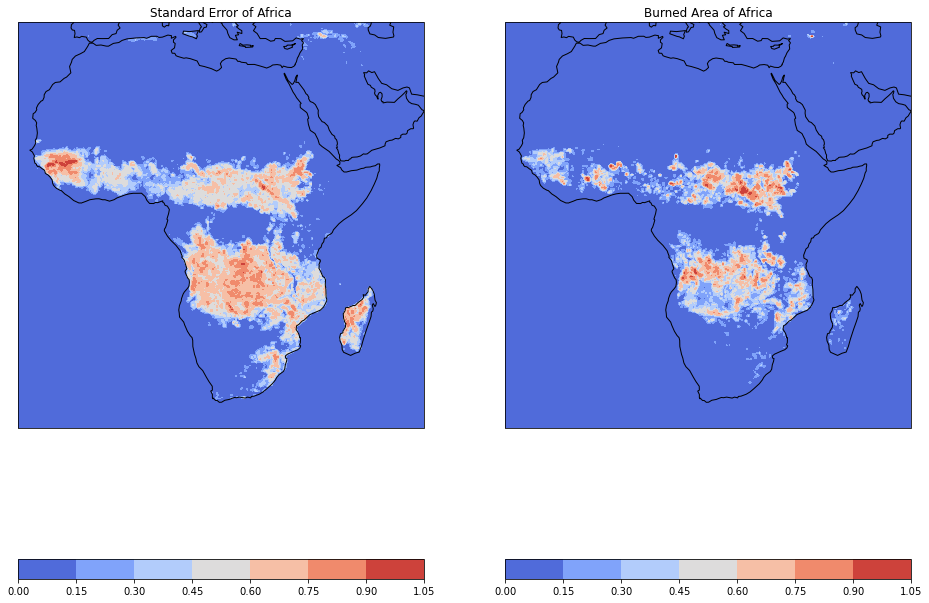

In [27]:
# fig = plt.figure(figsize=(8,8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ax.contourf(e_lon, e_lat, total_error_africa.to_numpy(), cmap=cm.coolwarm)
# plt.show()

fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(e_lon, e_lat, norm_total_error_africa, cmap=cm.coolwarm)
ax.set_title('Standard Error of Africa')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(e_lon,e_lat,norm_total_BA_africa,cmap=cm.coolwarm)
ax.set_title('Burned Area of Africa')
fig.colorbar(im, location='bottom')

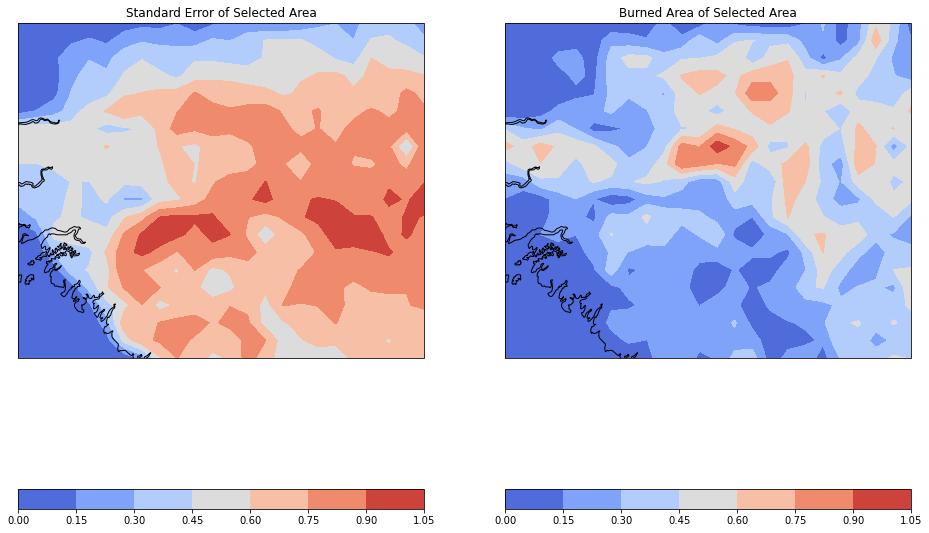

In [28]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(s_lon,s_lat,norm_selected_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(s_lon,s_lat,norm_selected_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of Selected Area')
fig.colorbar(im, location='bottom')

## Analyzing the Selected Area by Hypothesis

### Hypothesis 1. Cloudy would be related to high standard error
Comparision Standatd Error and Burned Area of Tropical Rainforest Climate Area in Africa

In [29]:
norm_BA = norm_selected_BA.flatten()
norm_error =norm_selected_error.flatten()

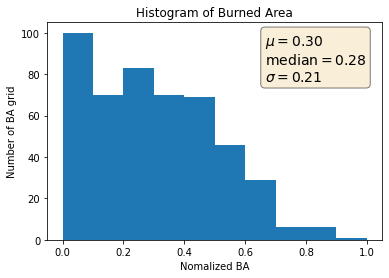

In [30]:
fig, ax = plt.subplots()
mu = np.mean(norm_BA)
median = np.median(norm_BA)
sigma = np.std(norm_BA)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.hist(norm_BA, 10)
plt.title('Histogram of Burned Area')
plt.xlabel('Nomalized BA')
plt.ylabel('Number of BA grid')
plt.show()

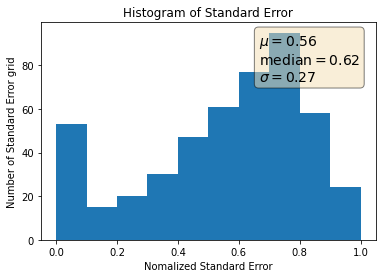

In [31]:
fig, ax = plt.subplots()
mu = np.mean(norm_error)
median = np.median(norm_error)
sigma = np.std(norm_error)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.hist(norm_error, 10)
plt.title('Histogram of Standard Error')
plt.xlabel('Nomalized Standard Error')
plt.ylabel('Number of Standard Error grid')
plt.show()


### Analyze the cloud cover and Total precipitation
#### Normalization

In [32]:
a_total_tp = total_tp - np.mean(total_tp)
a_total_tcc = total_tcc - np.mean(total_tcc)
a_total_hcc = total_hcc - np.mean(total_hcc)
a_total_mcc = total_mcc - np.mean(total_mcc)
a_total_lcc = total_lcc - np.mean(total_lcc)

norm_total_tp = NormalizeData(np.array(a_total_tp))
norm_total_tcc = NormalizeData(np.array(a_total_tcc))
norm_total_hcc = NormalizeData(np.array(a_total_hcc))
norm_total_mcc = NormalizeData(np.array(a_total_mcc))
norm_total_lcc = NormalizeData(np.array(a_total_lcc)) 


#### Histogram of Total Precipation Data for World

<function matplotlib.pyplot.show(close=None, block=None)>

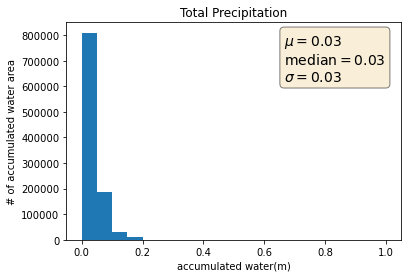

In [33]:
fig, ax = plt.subplots()
mu = np.mean(norm_total_tp.flatten())
median = np.median(norm_total_tp.flatten())
sigma = np.std(norm_total_tp.flatten())
textstr = '\n'.join((
    r'$\mu=%.2f$' % (mu, ),
    r'$\mathrm{median}=%.2f$' % (median, ),
    r'$\sigma=%.2f$' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.hist(norm_total_tp.flatten(),20)
plt.title('Total Precipitation')
plt.xlabel('accumulated water(m)')
plt.ylabel('# of accumulated water area')
plt.show

#### Histogram of Cloud Cover Data for World

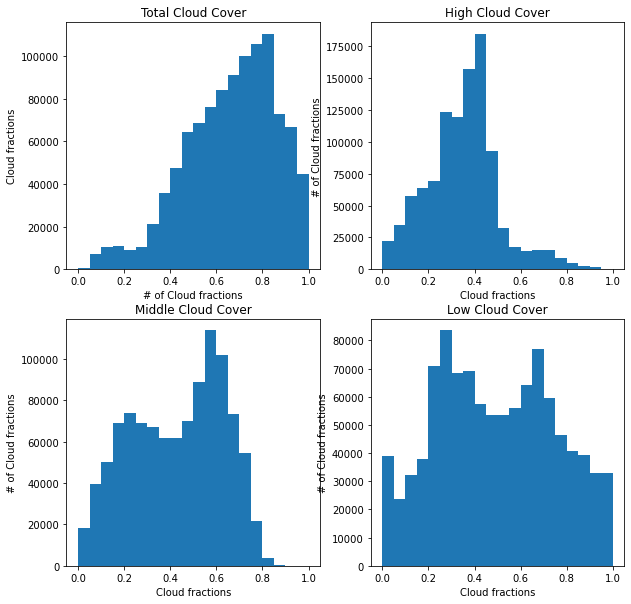

In [34]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(norm_total_tcc.flatten(),20)
plt.title('Total Cloud Cover')
plt.xlabel('# of Cloud fractions')
plt.ylabel('Cloud fractions')

plt.subplot(2, 2, 2)
plt.hist(norm_total_hcc.flatten(),20)
plt.title('High Cloud Cover')
plt.ylabel('# of Cloud fractions')
plt.xlabel('Cloud fractions')

plt.subplot(2, 2, 3)
plt.hist(norm_total_mcc.flatten(),20)
plt.title('Middle Cloud Cover')
plt.ylabel('# of Cloud fractions')
plt.xlabel('Cloud fractions')

plt.subplot(2, 2, 4)
plt.hist(norm_total_lcc.flatten(),20)
plt.title('Low Cloud Cover')
plt.ylabel('# of Cloud fractions')
plt.xlabel('Cloud fractions')

plt.show()

In [35]:
# fig = plt.figure(figsize=(10,10))
# plt.subplot(2, 2, 1)
# plt.plot(norm_total_tcc.flatten(),20)
# plt.title('Total Cloud Cover')
# plt.xlabel('# of Cloud fractions')
# plt.ylabel('Cloud fractions')

# plt.subplot(2, 2, 2)
# plt.plot(norm_total_hcc.flatten(),20)
# plt.title('High Cloud Cover')
# plt.ylabel('# of Cloud fractions')
# plt.xlabel('Cloud fractions')

# plt.subplot(2, 2, 3)
# plt.plot(norm_total_mcc.flatten(),20)
# plt.title('Middle Cloud Cover')
# plt.ylabel('# of Cloud fractions')
# plt.xlabel('Cloud fractions')

# plt.subplot(2, 2, 4)
# plt.plot(norm_total_lcc.flatten(),20)
# plt.title('Low Cloud Cover')
# plt.ylabel('# of Cloud fractions')
# plt.xlabel('Cloud fractions')

# plt.show()

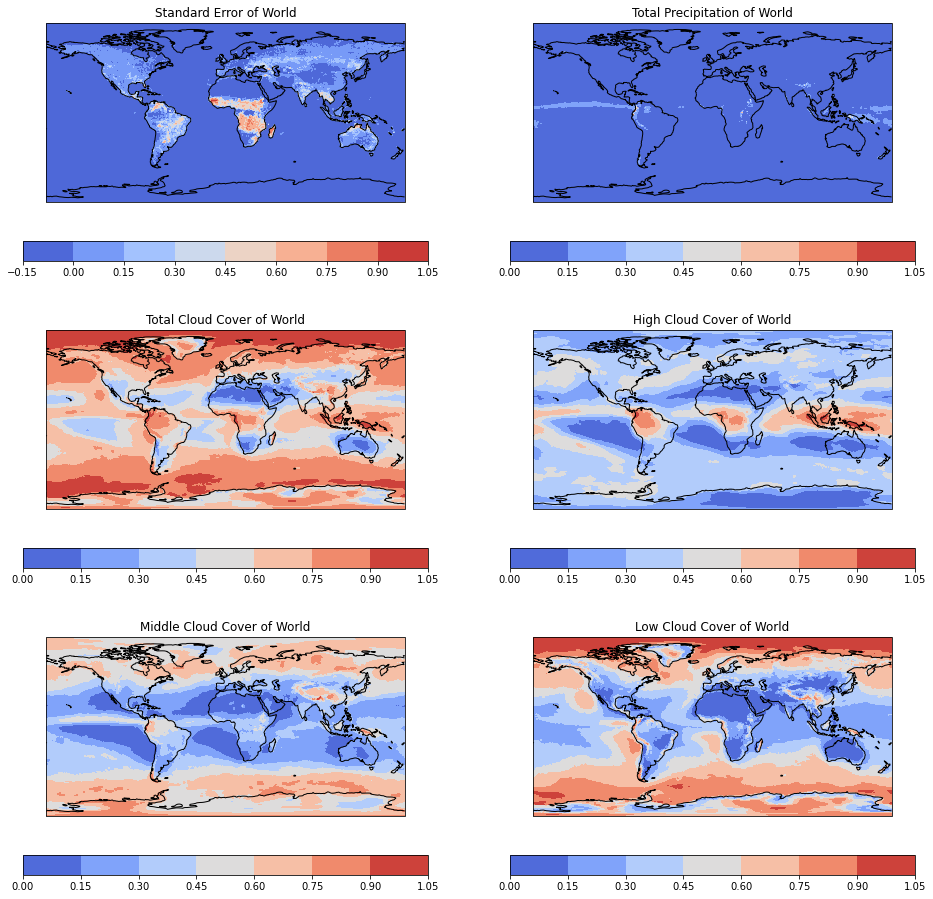

In [36]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon, lat, agg_anomaly_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_tp, cmap=cm.coolwarm)
ax.set_title('Total Precipitation of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_tcc, cmap=cm.coolwarm)
ax.set_title('Total Cloud Cover of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_hcc, cmap=cm.coolwarm)
ax.set_title('High Cloud Cover of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_mcc, cmap=cm.coolwarm)
ax.set_title('Middle Cloud Cover of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(3,2,6, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_lcc, cmap=cm.coolwarm)
ax.set_title('Low Cloud Cover of World')
fig.colorbar(im, location='bottom')


#### Histogram of Total Precipation & Cloud Cover Data for Selected Area

In [37]:
lat_min, lat_max = 10,15
lon_min, lon_max = -16,-10


norm_selected_tp , s__lat, s__lon = get_cropped_area(norm_total_tp,lat_min, lat_max, lon_min, lon_max)
norm_selected_tcc , s__lat, s__lon = get_cropped_area(norm_total_tcc,lat_min, lat_max, lon_min, lon_max)

lat_min_idx: 300, lat_max_idx:320
lon_min_idx: 656, lon_max_idx:680
lon_min_idx: -64, lon_max_idx:-40
There is NO NaN
SUCCESS: There is no NaN
lat_min_idx: 300, lat_max_idx:320
lon_min_idx: 656, lon_max_idx:680
lon_min_idx: -64, lon_max_idx:-40
There is NO NaN
SUCCESS: There is no NaN


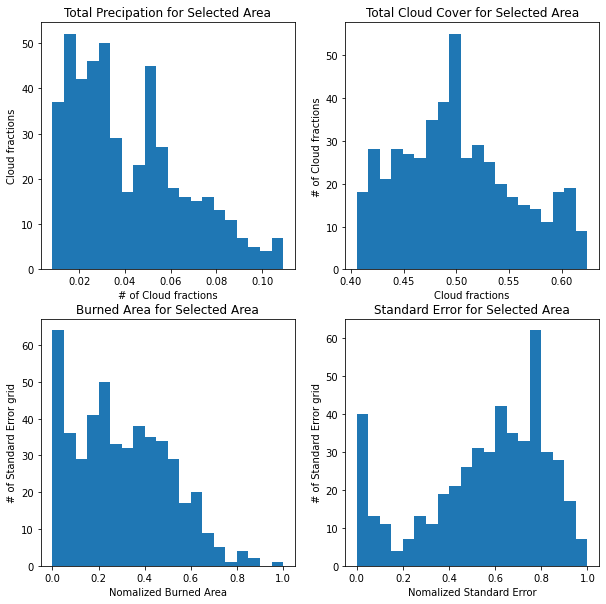

In [38]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(norm_selected_tp.to_numpy().flatten(),20)
plt.title('Total Precipation for Selected Area')
plt.xlabel('# of Cloud fractions')
plt.ylabel('Cloud fractions')

plt.subplot(2, 2, 2)
plt.hist(norm_selected_tcc.to_numpy().flatten(),20)
plt.title('Total Cloud Cover for Selected Area')
plt.ylabel('# of Cloud fractions')
plt.xlabel('Cloud fractions')

plt.subplot(2, 2, 3)
plt.hist(norm_BA,20)
plt.title('Burned Area for Selected Area')
plt.xlabel('Nomalized Burned Area')
plt.ylabel('# of Standard Error grid')

plt.subplot(2, 2, 4)
plt.hist(norm_error,20)
plt.title('Standard Error for Selected Area')
plt.xlabel('Nomalized Standard Error')
plt.ylabel('# of Standard Error grid')

plt.show()

#### Map of Total Precipation & Cloud Cover Data for Selected Area

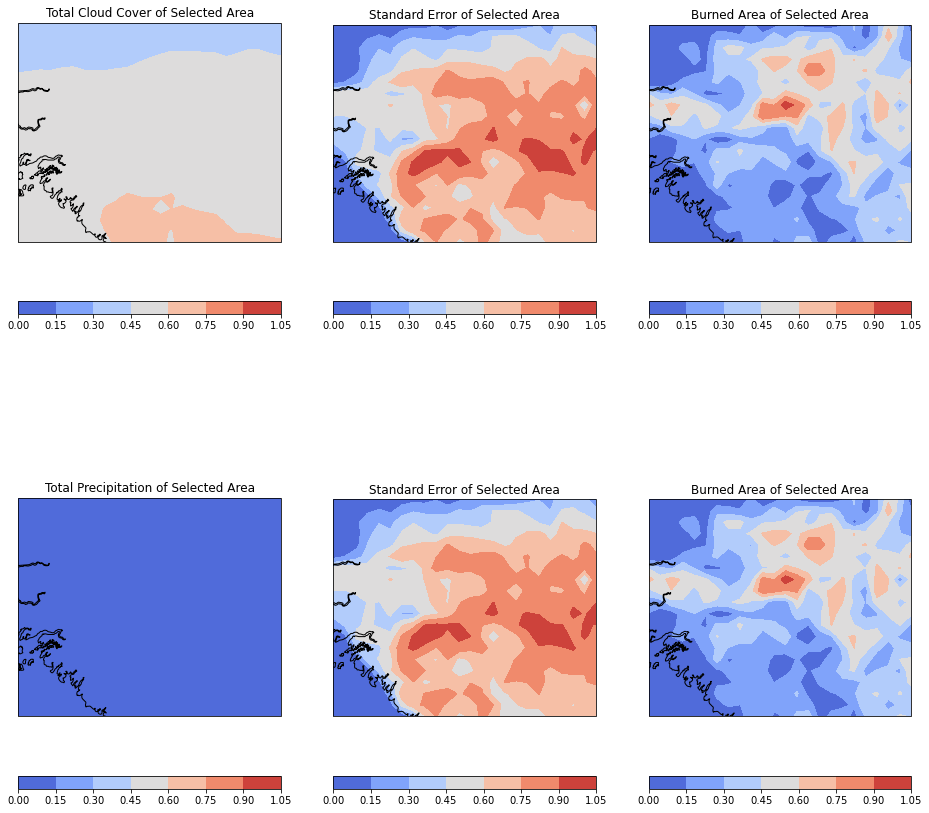

In [39]:
fig = plt.figure(figsize=(16,16))

# ax = fig.add_subplot(2, 3, 1, projection=ccrs.PlateCarree())
# ax.coastlines()
# im = ax.contourf(s__lon,s__lat,norm_selected_tcc,cmap=cm.coolwarm)
# ax.set_title('Total Cloud Cover of Africa')
# fig.colorbar(im, location='bottom')
ax = fig.add_subplot(2,3,1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.set_xlim([-16,-10])
ax.set_ylim([10,15])
im = ax.contourf(_lon, _lat, norm_total_tcc, cmap=cm.coolwarm)
ax.set_title('Total Cloud Cover of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(s_lon,s_lat,norm_selected_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2, 3, 3, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(s_lon,s_lat,norm_selected_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of Selected Area')
fig.colorbar(im, location='bottom')


ax = fig.add_subplot(2, 3, 4, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(_lon,_lat,norm_total_tp,cmap=cm.coolwarm)
            
ax.set_xlim([-16,-10])
ax.set_ylim([10,15])
ax.set_title('Total Precipitation of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2, 3, 5, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(s_lon,s_lat,norm_selected_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of Selected Area')
fig.colorbar(im, location='bottom')


ax = fig.add_subplot(2, 3, 6, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(s_lon,s_lat,norm_selected_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of Selected Area')
fig.colorbar(im, location='bottom')

### Hypothesis 2.  Low Vegetation would impact more on Burned Area

#### Comparing vegatation data with BA & SE data
* High vagetation -> more foreast, greener
* Low vegatation -> more land surface vegetation. e.g.crops and mixed farming, irrigated crops, short grass, tall grass, tundra, semidesert, bogs and marshes, evergreen shrubs, deciduous shrubs, and water and land mixtures.


#### 

In [40]:
a_total_hvc = total_hvc - np.mean(total_hvc)
a_total_cvl = total_cvl - np.mean(total_cvl)

norm_total_hvc = NormalizeData(np.array(a_total_hvc))
norm_total_cvl = NormalizeData(np.array(a_total_cvl))


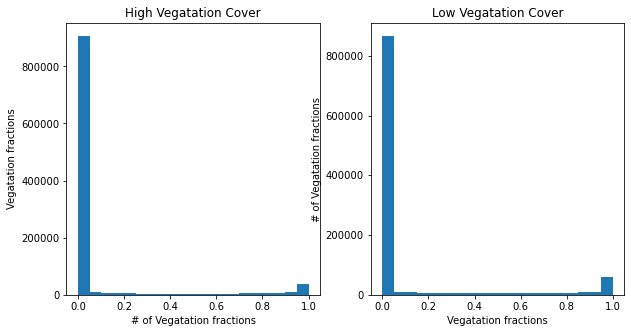

In [41]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(norm_total_hvc.flatten(),20)
plt.title('High Vegatation Cover')
plt.xlabel('# of Vegatation fractions')
plt.ylabel('Vegatation fractions')

plt.subplot(1, 2, 2)
plt.hist(norm_total_cvl.flatten(),20)
plt.title('Low Vegatation Cover')
plt.ylabel('# of Vegatation fractions')
plt.xlabel('Vegatation fractions')

plt.show()

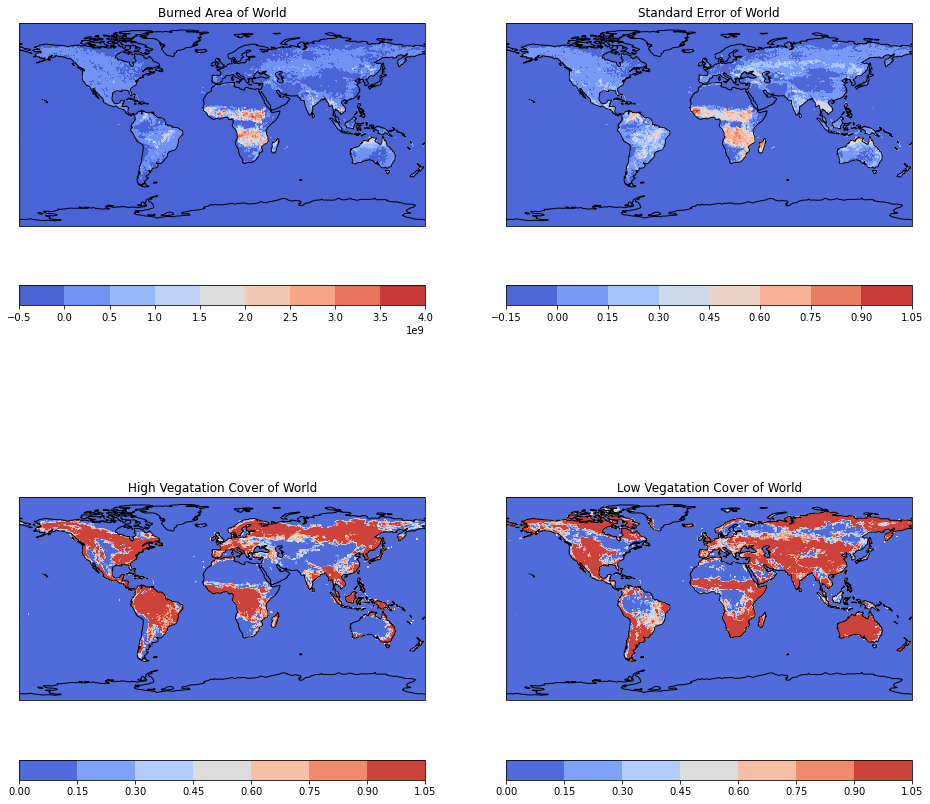

In [42]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon,lat,agg_anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
im = ax.contourf(lon, lat, agg_anomaly_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_hvc, cmap=cm.coolwarm)
ax.set_title('High Vegatation Cover of World')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.contourf(_lon, _lat, norm_total_cvl, cmap=cm.coolwarm)
ax.set_title('Low Vegatation Cover of World')
fig.colorbar(im, location='bottom')


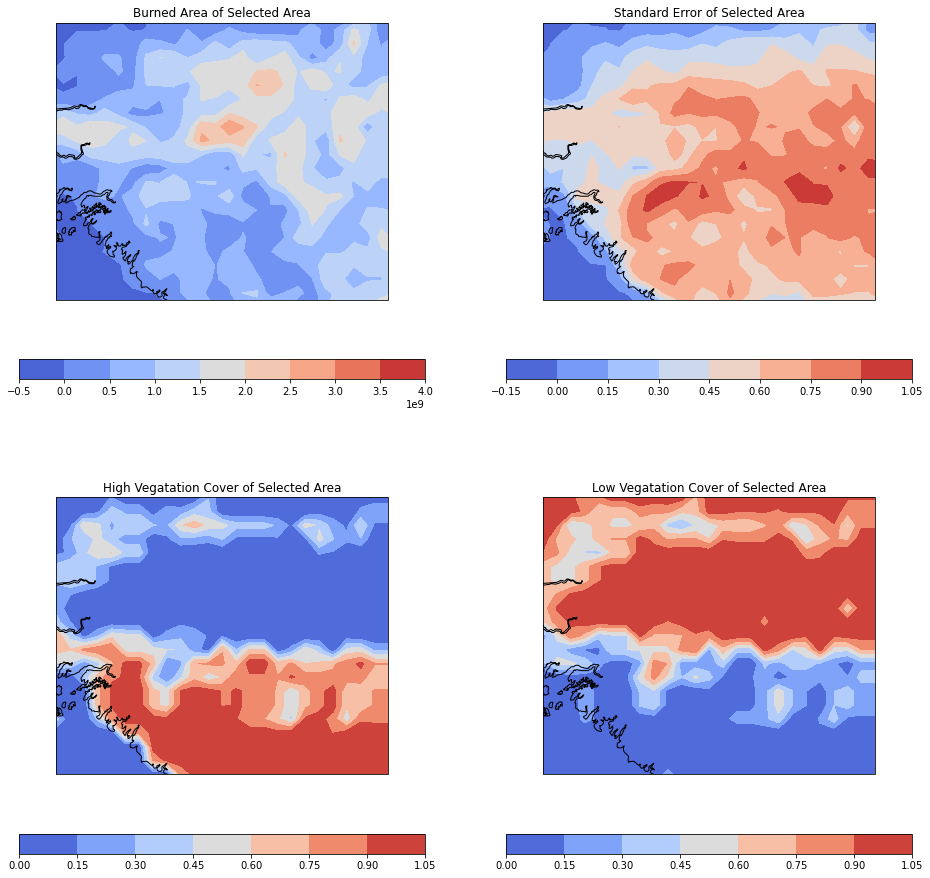

In [43]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(2,2,1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.set_xlim([-16,-10])
ax.set_ylim([10,15])
im = ax.contourf(lon,lat,agg_anomaly_BA,cmap=cm.coolwarm)
ax.set_title('Burned Area of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2,2,2, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.set_xlim([-16,-10])
ax.set_ylim([10,15])
im = ax.contourf(lon, lat, agg_anomaly_error, cmap=cm.coolwarm)
ax.set_title('Standard Error of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim([-16,-10])
ax.set_ylim([10,15])
im = ax.contourf(_lon, _lat, norm_total_hvc, cmap=cm.coolwarm)
ax.set_title('High Vegatation Cover of Selected Area')
fig.colorbar(im, location='bottom')

ax = fig.add_subplot(2,2,4, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim([-16,-10])
ax.set_ylim([10,15])
im = ax.contourf(_lon, _lat, norm_total_cvl, cmap=cm.coolwarm)
ax.set_title('Low Vegatation Cover of Selected Area')
fig.colorbar(im, location='bottom')


In [44]:
lat_min, lat_max = 10,15
lon_min, lon_max = -16,-10


norm_selected_hvc , s__lat, s__lon = get_cropped_area(norm_total_hvc,lat_min, lat_max, lon_min, lon_max)
norm_selected_cvl , s__lat, s__lon = get_cropped_area(norm_total_cvl,lat_min, lat_max, lon_min, lon_max)

lat_min_idx: 300, lat_max_idx:320
lon_min_idx: 656, lon_max_idx:680
lon_min_idx: -64, lon_max_idx:-40
There is NO NaN
SUCCESS: There is no NaN
lat_min_idx: 300, lat_max_idx:320
lon_min_idx: 656, lon_max_idx:680
lon_min_idx: -64, lon_max_idx:-40
There is NO NaN
SUCCESS: There is no NaN


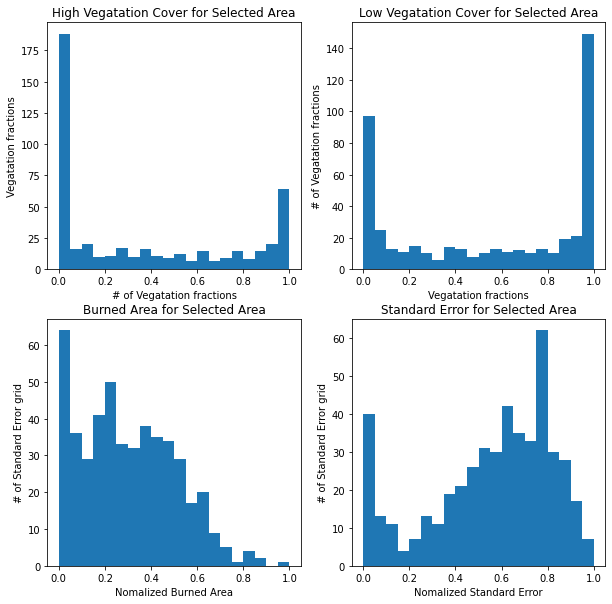

In [45]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.hist(norm_selected_hvc.to_numpy().flatten(),20)
plt.title('High Vegatation Cover for Selected Area')
plt.xlabel('# of Vegatation fractions')
plt.ylabel('Vegatation fractions')

plt.subplot(2, 2, 2)
plt.hist(norm_selected_cvl.to_numpy().flatten(),20)
plt.title('Low Vegatation Cover for Selected Area')
plt.ylabel('# of Vegatation fractions')
plt.xlabel('Vegatation fractions')

plt.subplot(2, 2, 3)
plt.hist(norm_BA,20)
plt.title('Burned Area for Selected Area')
plt.xlabel('Nomalized Burned Area')
plt.ylabel('# of Standard Error grid')

plt.subplot(2, 2, 4)
plt.hist(norm_error,20)
plt.title('Standard Error for Selected Area')
plt.xlabel('Nomalized Standard Error')
plt.ylabel('# of Standard Error grid')

plt.show()